In [2]:
import time
start = time.time()

In [3]:
#IMPORTS
from datetime import datetime
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
import pyspark.sql.functions as F
from math import sin, cos, sqrt, atan2, radians 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator
import copy


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
#parameters
interval=30 #time window
th=1 #distance
window_size=3 #window size
maxDelta=3 #how many delta
support=0
support_str="0"
station_status= "StateChange_Normal_almostFull"

In [5]:
#FILES
#Considero soltanto le stazioni di San Francisco
inputPath  = "file:///home/bigdata-01QYD/s270240/bike_sharing/Associative_classifier/Datasets/SanFrancisco_status_train.csv"
STATION_PATH="file:///home/bigdata-01QYD/s270240/bike_sharing/station.csv"
#save file of first filter
output_file=f'./Results_extraction/{interval}min_{int(th*1000)}m/{results_{station_status}_{interval}_{int(th*1000)}_{support_str}({window_size}-{maxDelta})_ordered_by_confidence.txt'


In [6]:
inputDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(inputPath)

In [7]:
inputDF=inputDF.filter("docks_available is not null")

In [8]:
#filter for these fields
filteredDF = inputDF.filter("docks_available<>0 OR bikes_available<>0")

In [9]:
# SFancisco_stations = [41, 42, 45, 46, 47, 48, 49, 50, 51, 39, 54, 55, 56, 57, 58, 59, 60, 
#                       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 82]
# filteredDF = filteredDF[filteredDF['station_id'].isin(SFancisco_stations)]
# filteredDF.collect()

In [10]:
#determine if the station is normal or almost full
def stateFunction(docks_available,bikes_available):
    if docks_available<=2: # almostFull
        return 1
    else:         #normal
        return 0

In [11]:
spark.udf.register("state", stateFunction)

<function __main__.stateFunction(docks_available, bikes_available)>

In [12]:
def getInt(station):
    return (station)

In [13]:
spark.udf.register("intValue", getInt)

<function __main__.getInt(station)>

In [14]:
getStatusDF = filteredDF.selectExpr("station_id","time", "state(docks_available,bikes_available) as status")

In [15]:
# getStatusDF.show(100,False)

In [16]:
#create a view
getStatusDF.createOrReplaceTempView("readings")

In [17]:
#select station, year, month, day, hour, minute, status ordered by time
ss=spark.sql("""SELECT  station_id , YEAR(time) as year, MONTH(time) as month, DAY(time) as day, HOUR(time)as hour, MINUTE(time) as minute, status
FROM readings
GROUP BY station_id, year, month, day,hour,minute, status
ORDER BY  station_id,year, month,day, hour,minute
""")

In [18]:
#create rdd and group into interval
my_rdd=ss.rdd.map(tuple)
rdd=my_rdd.map(lambda line: (line[0],line[1],line[2], line[3], line[4], int(line[5]/interval), line[6])).distinct()

In [19]:
# rdd.collect()

# [(6, 2013, 12, 31, 1, 1, '2'),
#  (6, 2014, 1, 14, 22, 1, '2'),
#  (6, 2014, 1, 16, 0, 1, '2'),
#  (6, 2014, 1, 19, 6, 0, '2'),
#  (6, 2014, 1, 23, 21, 1, '2'),
#  (6, 2014, 1, 26, 10, 1, '2'),
#  (6, 2014, 1, 30, 14, 1, '2'), ... ]

In [20]:
#get distinct stations to calculate distances
id_stations=rdd.map(lambda line: line[0]).distinct()

In [21]:
tot_id_stations=id_stations.collect()

In [22]:
#obtain timestamp and info
def getMap2(line):
    id_station=str(line[0])
    year=int(line[1])
    month=int(line[2])
    day=int(line[3])
    hour=int(line[4])
    minute=int(line[5])   
    timestamp= datetime(year,month, day, hour, minute)  
    status=int(line[6])
    info=str(id_station)+' '+str(status)
    return (timestamp, info)

In [23]:
get_map2=rdd.map(getMap2)

In [24]:
# get_map2.collect()

# [(datetime.datetime(2014, 3, 31, 18, 1), '11 2'),
#  (datetime.datetime(2014, 4, 6, 21, 0), '11 2'),
#  (datetime.datetime(2014, 4, 10, 22, 1), '11 2'),
#  (datetime.datetime(2014, 4, 12, 8, 1), '11 2'),
#  (datetime.datetime(2014, 4, 13, 8, 0), '11 2'), ... ]

In [25]:
reduceK2=get_map2.reduceByKey(lambda l1,l2 :(l1+','+l2)).sortByKey()

In [26]:
# reduceK2.collect()

# [(datetime.datetime(2013, 8, 29, 10, 0), '59 0,67 0,4 1,13 1,67 1,6 0,2 0,7 1,16 0,70 1,70 0'),
#  (datetime.datetime(2013, 8, 29, 10, 1), '67 0,7 1,16 0,59 0,13 1,67 1,70 0,2 0,7 0,69 0,4 1,13 0,73 0'),
#  (datetime.datetime(2013, 8, 29, 11, 0), '67 1,2 0,4 0,73 0,67 0,69 0,16 0,70 0,4 1'),
#  (datetime.datetime(2013, 8, 29, 11, 1), '16 0,73 0,2 0,69 0,67 0'),
#  (datetime.datetime(2013, 8, 29, 12, 0), '69 1,69 0,16 0,2 0,73 0'), ... ]

In [27]:
list_tot=reduceK2.collect()

In [28]:
# list_tot[:5]

In [29]:
voc_status={}
voc_timestamp={}
list_filtered=[]

voc_tmp={}

# previous_list=[]
# updated_list=[]

for i, el in enumerate(list_tot):
    #updated_list=[]    
    information=el[1]   
    tmp_list_station='' 
    voc_tmp={}
    
    for info in information.split(','):
#         print()
#         print(info)
        station=str(info.split(' ')[0])
            
        status=int(info.split(' ')[1])
        if  station not in voc_status:
#             print (f"station: {station} NOT PRESENT")
            voc_status[station]=status
            tmp_time= el[0].replace(minute=el[0].minute*interval) #riconverto nei minuti originali 
            voc_timestamp[station]=tmp_time
#             print (f"actual_time: {voc_timestamp[station]}")
            stringa=''
            if status==1:
                stringa='QuasiPiena'
            else:
                stringa='Normal'    
            tmp_list_station+=','+station+'_'+ stringa 
#             print(tmp_list_station)
            #updated_list.append(station)
                  
        else:
#             print (f"station: {station} PRESENT")
            times=voc_timestamp[station]
#             print (f"times: {times}")
            tmp_time= el[0].replace(minute=el[0].minute*interval) #riconverto nei minuti originali
            actual_time=tmp_time
#             print (f"actual_time: {actual_time}")
#             print (f"old satus: {voc_status[station]}")
#             print (f"new satus: {status}")
            
            if times == actual_time:    #inside same timeslot
                if status != voc_status[station]:   # if status changed   
#                     print("STATUS CHANGED INSIDE THE SAME TIMESLOT!!!!!")
                    voc_status[station]=3  #set flag of status changed inside same timeslot
                    stringa=''
                    if status==1:
                        stringa='QuasiPiena'
                    else:
                        stringa='Normal'    
                    tmp_list_station+=','+station+'_'+ stringa 
#                     print(tmp_list_station)
                    
            else:            # different timeslot
#                 print(f"actual_time.minute-times.minute: {int((actual_time-times).total_seconds() / 60.0)}")
#                 if ((actual_time.hour == times.hour and actual_time.minute-times.minute==1) or
#                     (actual_time.hour-times.hour==1 and actual_time.minute-times.minute==-1)):
                
                if (int((actual_time-times).total_seconds() / 60.0)== interval): # after less than 30 minutes
#                     print(f"after <= 30 minutes")
                    if voc_status[station]==3:         #if status changed inside the same old timeslot        
#                         print("STATUS CHANGED INSIDE THE SAME OLD TIMESLOT!!!!!")
                        voc_status[station]=status     #update old status with new one
                        voc_timestamp[station]=actual_time      #update old timestamp with new one
                        stringa=''
                        if status==1:
                            stringa='QuasiPiena'
                        else:
                            stringa='Normal'
                        tmp_list_station+=','+station+'_'+ stringa 
#                         print(tmp_list_station)
                        #updated_list.append(station)
                        
                    elif voc_status[station] != status:  # if status changed between old and new timeslot 
#                         print("STATUS CHANGED!!!!!")
                        voc_status[station]=status     #update old status with new one
                        voc_timestamp[station]=actual_time    #update old timestamp with new one
                        stringa=''
                        if status==1:
                            stringa='QuasiPiena'
                        else :
                            stringa='Normal'
                        tmp_list_station+=','+station+'_'+ stringa 
#                         print(tmp_list_station)
                        
                        if station in voc_tmp:
                            if voc_tmp[station]==1:
                                 tmp_list_station+=','+station+'_QuasiPiena'
                            elif voc_tmp[station]==0:
                                 tmp_list_station+=','+station+'_Normal'
                            
#                             print(tmp_list_station)
                        
                        
                    elif  voc_status[station] == status: # if status did not change between old and new timeslot
#                         print("STATUS DID NOT CHANGE!!!!!")
                        voc_tmp[station]=status
                        tmp_list_station+=','+station+'_NoChange'
#                         print(tmp_list_station)
#                         voc_timestamp[station]=actual_time     #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                    
                # after more than 30 minutes        
                else:
#                     print(f"after >= 30 minutes")
                    if voc_status[station] != status:
                        stringa=''
                        if status==1:
                            stringa='QuasiPiena'
                        else :
                            stringa='Normal'
                        tmp_list_station+=','+station+'_'+ stringa 
#                         print(tmp_list_station)
                    else:
                        tmp_list_station+=','+station+'_NoChange'
#                     print (f"REMOVING STATION {station}")    
#                     del voc_status[station]
#                     del voc_timestamp[station]
                    voc_timestamp[station]=actual_time
                
    
    list_filtered.append((el[0],tmp_list_station[1::]))

In [30]:
reduceK=spark.sparkContext.parallelize(list_filtered)


In [31]:
# reduceK.collect()

In [32]:
my_df=reduceK.toDF()
#my_df.collect()

In [33]:
my_df.createOrReplaceTempView("view")

In [34]:
s2=spark.sql("""SELECT ROW_NUMBER() OVER(ORDER BY _1,_2) as id ,_1, _2
FROM view """)

In [35]:
#identifier of the timestamp, info
rdd_scheme=s2.rdd.map(tuple).map(lambda line: (line[0], line[2]))

In [36]:
# rdd_scheme.collect()

In [37]:
#obtain window, station-status
def giveSplit(line):   
    id_window=( int(line[0] ))
    lista=[]    
    counter=id_window    
    while counter>=1:
        lista.append(('Window '+str(counter),(line[1])))
        counter=counter-1
        if (id_window-counter)==window_size:
            return lista  
    return lista

In [38]:
mapData=rdd_scheme.flatMap(giveSplit)

In [39]:
# mapData.collect()

In [40]:
filteredD=mapData.filter(lambda line: line[1]!='')

In [41]:
# filteredD.collect()

In [42]:
# for each window get all info
all_keys=filteredD.reduceByKey(lambda l1,l2:(l1+'-'+l2))

In [43]:
# all_keys.collect()

In [44]:
#finestra temporale
def reduceKeys(line):   
    lista=[]
    #lista.append(line[0])
    line_split=line[1].split("-")
    #return line_split[0]
    count=len(line_split)
    tot=[]
    for val in range(count):
        li=[]
        stations=line_split[val].split(',')
        for st in stations:
            all_string_st=st.split('_')[0]+'_'+'T'+str(val)+'_'+st.split('_')[1]
            li.append(all_string_st)
        tot.append(li)
    lista.append((line[0],(tot))) 
    return lista

In [45]:
windows=all_keys.flatMap(reduceKeys)

In [46]:
# windows.collect()

In [47]:
#filtering NoChange events
def filterNormal(line):
    complete_list = []
    for list_el in line[1]:
        event_list = copy.deepcopy(list_el)
        for el in list_el:
            if "NoChange"in el:
                event_list.remove(el)
#         new_event_list = ",".join(event_list)
        complete_list.append(event_list)
    return (line[0], complete_list)

In [48]:
#remove normal and noChange events

windows_withoutNormal = windows.map(filterNormal)
# windows_withoutNormal.collect()

# [('Window 1',
#   [[],
#    ['60_T1_QuasiPiena', '64_T1_QuasiPiena', '45_T1_Piena', '45_T1_QuasiPiena'],
#    ['45_T2_Piena', '64_T2_Piena', '64_T2_QuasiPiena', '45_T2_QuasiPiena']]),
#  ('Window 2',
#   [['60_T0_QuasiPiena', '64_T0_QuasiPiena', '45_T0_Piena', '45_T0_QuasiPiena'],
#    ['45_T1_Piena', '64_T1_Piena', '64_T1_QuasiPiena', '45_T1_QuasiPiena'],
#    ['64_T2_QuasiPiena', '35_T2_QuasiPiena']]),... ]

In [49]:
#filtering empty list ''
def filterEmptyList(line):
    filtered_list = list(filter(None, line[1]))
    return (line[0], filtered_list)

In [50]:
filtered_windows = windows_withoutNormal.map(filterEmptyList)
# filtered_windows.collect()

In [51]:
#filtering empty window
filtered_windows2 = filtered_windows.filter(lambda line: line[1])
# filtered_windows2.collect()

In [52]:
#save station file
stationsDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(STATION_PATH)

In [53]:
#get only rows interested: only the used stations 
necessary_rows=stationsDF.filter(F.col("id").isin(tot_id_stations)).sort("id").rdd.map(tuple)

In [54]:
#necessary_rows.collect()

In [55]:
#get info of stations about coordinates and name
coordinates=necessary_rows.map(lambda line: (line[0],(str(line[2])+','+str(line[3]))))
names_stations=necessary_rows.map(lambda line: (line[0],line[1]))

In [56]:
list_coo=coordinates.collect()

In [57]:
# list_coo

# [(2, '37.329732,-121.90178200000001'),
#  (3, '37.330698,-121.888979'),
#  (4, '37.333988,-121.894902'),
#  (5, '37.331415,-121.8932'),
#  (6, '37.336721000000004,-121.894074'), ...]

In [58]:
#create a dictionary in which the key is the station and value is the info about coordinates
dic_co=coordinates.collectAsMap()
dic_coordinates=sc.broadcast(dic_co)
#dic_coordinates.value[1]

In [59]:
#function to retrieve distance between 2 stations
def getDistance(station1,station2):
    # approximate radius of earth in km
    R = 6373.0    
    lat_a=float(station1.split(',')[0])
    lat_b=float(station2.split(',')[0])
    long_a=float(station1.split(',')[1])
    long_b=float(station2.split(',')[1])
    
    lat1=radians(lat_a)
    lat2=radians(lat_b)
    lon1=radians(long_a)
    lon2=radians(long_b)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [60]:
#voc in which the key is a pair of stations and value is the distance
voc_distances={}
for i in range(len(list_coo)):
    for j in range(i+1,len(list_coo)):
        station1=list_coo[i][0]
        station2=list_coo[j][0]
        d_i=list_coo[i][1]
        d_j=list_coo[j][1]
        distance=getDistance(d_i,d_j)
        id_stations=str(station1)+' '+str(station2)
        voc_distances[id_stations]=distance

In [61]:
# voc_distances['2 3']

In [68]:
#Applicazione “Delta Spaziale”
def giveSpatialWindow(line):
    lista=[]    
    time0=line[1][0]    #
    dic={}
    
    count_windows=len(line[1])#tot windows

    for station in time0:# only first window
        act_station=int(station.split('_')[0])
        #lista_station=[] 
        list_tmp=[]
        
        #for each window
        for i,window in enumerate(line[1]):           
            second_lista=[]
            #for each element of a window
            for all_el in window :
                #second_lista=[]
                
                act_all_el=int(all_el.split('_')[0])
                time_window= all_el.split('_')[1]
                state=all_el.split('_')[2]
               
                if act_station!=act_all_el:
                    
                    key=''
                    if act_station<act_all_el:
                        key=str(act_station)+' '+str(act_all_el)
                    else:
                        key=str(act_all_el)+' '+str(act_station)                    
                    
                    dist=voc_distances[key]
                    if dist<=maxDelta*th:
                        delta=0
                        for d in range(1,maxDelta+1):
                            if d*th>=dist:
                                delta=d
                                break                        
                        string=state+'_'+time_window+'_'+str(delta)
                        second_lista.append(string)
                else:
                    string=state+'_'+time_window+'_'+str(0)
                    second_lista.append(string)
                    
            if len(second_lista)>0:
                list_tmp.append(second_lista)
        lista.append(((line[0]+'|'+str(act_station)),list_tmp))
    
    return lista

In [69]:
spatial_app=filtered_windows2.flatMap(giveSpatialWindow)
print(spatial_app.count())

49458


In [70]:
# spatial_app.collect()

# [('Window 1|59',
#   [['QuasiVuota_T0_0', 'QuasiVuota_T0_1', 'Vuota_T0_1', 'Vuota_T0_3', 'QuasiVuota_T0_3'],
#    ['QuasiVuota_T1_1', 'Vuota_T1_1', 'QuasiVuota_T1_3', 'QuasiVuota_T1_3', 'QuasiVuota_T1_3']]),
#  ('Window 1|67',
#   [['QuasiVuota_T0_1', 'QuasiVuota_T0_0', 'Vuota_T0_0', 'Vuota_T0_2', 'QuasiVuota_T0_2'],
#    ['QuasiVuota_T1_0', 'Vuota_T1_0', 'QuasiVuota_T1_2', 'QuasiVuota_T1_2', 'QuasiVuota_T1_3']]), ...]

In [71]:
def row_seq(line):
    true=line[1]
    string=Row(sequence=true)
    return string

In [72]:
spatial=spatial_app.map(row_seq)

In [73]:
# spatial.collect()

In [74]:
# seq_rdd =spatial.rdd.map(tuple)
filtered_seq = spatial.filter(lambda line: "T0" in line[0][0][0])
# filtered_seq.collect()

In [75]:
#create a dataframe
df=filtered_seq.toDF()
# len(df)

In [76]:
supports=[support]

In [77]:
df.show(20,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sequence                                                                                                                                                                                                                                                                                                                                                       

In [78]:
#prefixspan to obtain sequence and frequence
counter=[]
for support in supports:
    print(support)
    prefixSpan = PrefixSpan(minSupport=support, maxPatternLength=5,
                        maxLocalProjDBSize=5000)
    prefix=prefixSpan.findFrequentSequentialPatterns(df)   
    len_prefix=prefix.count()    
#     prefix.show(len_prefix,False)
    counter.append(len_prefix)

0


In [79]:
len_prefix

101579

In [80]:
pre=prefix.rdd.map(tuple)

In [81]:
# pre.collect()

# [([['QuasiPiena_T0_1']], 22981),
#  ([['Piena_T1_1']], 9208),
#  ([['QuasiPiena_T2_1']], 21641),
#  ([['Piena_T2_2']], 12794),
#  ([['QuasiPiena_T2_3']], 18047),
#  ([['Piena_T2_3']], 6994),
#  ([['Piena_T1_0']], 17930),
#  ([['QuasiPiena_T0_3']], 18099), ... ]

In [82]:
def giveSelected(line):
    seq=line[0]
    found=False   
    for window in seq:
        for el in window:
            if 'T0' in el and '_0' in el:
                found=True
                break
    return found 

In [83]:
giveT0=pre.filter(giveSelected)

In [85]:
df2=giveT0.toDF().withColumnRenamed('_1','sequence')
df2=df2.withColumnRenamed('_2','freq')#.show(len_prefix,False)

In [86]:
#df2.show()

In [87]:
def mapValues(line):
    seq=line[0]
    final=''
    #voc[seq]=line[1]
    for i,window in enumerate(seq):
        if i>0:
            final+='-'
        for j,el in enumerate(window):
            if j>0:
                final+=','
            final+=el
    final+=(';'+str(line[1])+';'+str(i))
    return final  

In [88]:
mapDict=giveT0.map(mapValues)

In [89]:
# mapDict.collect()

# ['QuasiVuota_T0_0;282;0',
#  'Vuota_T0_0;192;0',
#  'QuasiVuota_T0_0,Vuota_T0_3;2;0',
#  'QuasiVuota_T0_0,Vuota_T0_3-QuasiVuota_T1_1;1;1',
#  'QuasiVuota_T0_0,Vuota_T0_3-QuasiVuota_T1_1,QuasiVuota_T1_3;1;1', ...]

In [90]:
li=mapDict.collect()
voc={}

In [91]:
for el in li:
    splits=el.split(';')
    voc[splits[0]]=int(splits[1])

In [92]:
# voc

# {'QuasiVuota_T0_0': 88948,
#  'Vuota_T0_0': 44987,
#  'Vuota_T0_0-QuasiVuota_T1_2': 33837,
#  'QuasiVuota_T0_0-Vuota_T1_0': 26011,
#  'QuasiVuota_T0_2,Vuota_T0_0': 34141, ...}

In [93]:
repeated_el_window=0
for el in voc.keys():
    flag_rep=False
    windows=el.split('-')
    for w in windows:
        tot_items=len(w.split(','))
        set_items=len(set(w.split(',')))
        if tot_items!=set_items:
            repeated_el_window+=1
            break
repeated_el_window

9900

In [94]:
voc_supports={}
for el in voc.keys():    
    if len(el.split('-'))>1:        
        num=int(voc[el])       
        string=''
        tot=el.split('-')[:-1]
        for k,station in enumerate(tot):
            if k>0:
                string+='-'
            string+=station
        #print(string)
        den=int(voc[string])
        voc_supports[el]=str(num/den)+' - '+str(voc[el])
keys=list(voc_supports.keys())
values=list(voc_supports.values())

In [95]:
# voc_supports

# {'Vuota_T0_0-QuasiVuota_T1_2': '0.7521506212905951 - 33837',
#  'QuasiVuota_T0_0-Vuota_T1_0': '0.29242928452579037 - 26011',
#  'Vuota_T0_0-QuasiVuota_T2_3': '0.4979438504456843 - 22401',
#  'Vuota_T0_0-Vuota_T2_3': '0.28939471402849715 - 13019',
#  'QuasiVuota_T0_0-QuasiVuota_T2_0': '0.3469780096236003 - 30863', ...}

In [96]:
#sort vocabulary by decreasing values and sort within each window
tot_frequence=0
for key in voc_supports:    
    splitted=key.split('-')      
    splitted.sort()
    tmp_frequence=int(voc_supports[key].split(' - ')[1])
    tot_frequence+=tmp_frequence
for key in voc_supports:
    freq= int(voc_supports[key].split(' - ')[1])
    #print(freq)
#     perc_value=float("{:.2f}".format(freq*100/tot_frequence))
    voc_supports[key]=str(voc_supports[key].split(' - ')[0])+' - ' + str(freq)#+' - '+str(perc_value)+'%'  
# voc_supports = dict(sorted(voc_supports.items(), key=operator.itemgetter(1),reverse=True))
voc_supports = dict(sorted(voc_supports.items(), 
                           key=lambda v: (float(v[1].split(' - ')[0]), int(v[1].split(' - ')[1])),
                           reverse=True))

In [97]:
file = open(output_file, "w")

In [98]:
list_pattern=[]

In [99]:
for el in voc_supports:
    key_list=[]
    for e in el.split('-'):
        key_list.append([e])
    list_pattern.append([[key_list], [voc_supports[el]]])

In [100]:
file.write('Pattern, Confidence-Frequence'+'\n')
file.write(f'Total number of input patterns: {len(voc_supports)}'+'\n')
for el in list_pattern:  
    file.write(str(el)+ '\n')    
file.close() 

In [101]:
# voc_supports

In [102]:
tot_list=[]
for i, j in zip(keys,values):
    key_list=[]
    for el in i.split('-'):
        key_list.append([el])
    tot_list.append([[key_list], [j]])

In [103]:
confidence=[]
for el in values:
    #print(el.split('-')[0])
    val=round(float(el.split(' - ')[0]),2)
    confidence.append(val)
#confidence    

NameError: name 'img_support' is not defined

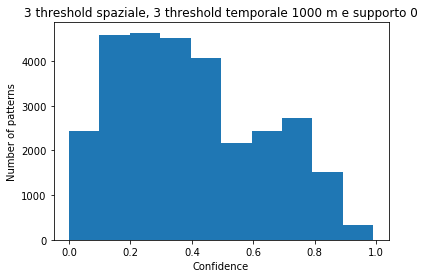

In [104]:
plt.hist(confidence)
plt.xlabel('Confidence')
plt.ylabel('Number of patterns')
plt.title(f'{maxDelta} threshold spaziale, {window_size} threshold temporale {th*1000} m e supporto {support}')
# plt.savefig(img_support)
plt.show()

In [ ]:
end = time.time()
print(f'The time of execution is: {end-start} s')